**Selección de 3 Modelos de Transfer learning para proyecto de clasificacion de insecto**

In [1]:
import zipfile
import os
zip_ref = zipfile.ZipFile('insects.v2-release.multiclass.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()
os.listdir('/content')

['.config',
 'valid',
 'insects.v2-release.multiclass.zip',
 'train',
 'README.dataset.txt',
 'test',
 'README.roboflow.txt',
 'sample_data']

In [ ]:
!pip show tensorflow

Name: tensorflow
Version: 2.15.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine-rl, tf_keras


In [2]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_df = pd.read_csv('/content/train/_classes.csv')
valid_df = pd.read_csv('/content/valid/_classes.csv')
test_df = pd.read_csv('/content/test/_classes.csv')

In [3]:

train_df = pd.read_csv('/content/train/_classes.csv')
print(train_df.head())


                                          filename   army worm  \
0  118_jpg.rf.33f3543dc18f61284c8c547271b971ee.jpg           0   
1   48_jpg.rf.343afaa10fac0ce192d82bc237560b7d.jpg           0   
2  135_jpg.rf.343c0d9db6b5760008f26cd22a9686a1.jpg           0   
3   45_jpg.rf.353c0fa30afa6db870959deaa6cf7dea.jpg           0   
4  139_jpg.rf.361b0984c39459ea357f7617448c818c.jpg           0   

    legume blister beetle   red spider   rice gall midge   rice leaf roller  \
0                       0            0                 1                  0   
1                       0            0                 0                  0   
2                       0            1                 0                  0   
3                       0            0                 0                  1   
4                       0            0                 0                  0   

    rice leafhopper   rice water weevil   wheat phloeothrips  \
0                 0                   0                    0   


In [4]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

# Función para obtener etiquetas de un dataframe de one-hot encoding
def get_label_from_one_hot(dataframe):
    return dataframe.iloc[:, 2:].idxmax(axis=1)

# Cargar los datos de los archivos CSV
train_df = pd.read_csv('/content/train/_classes.csv')
valid_df = pd.read_csv('/content/valid/_classes.csv')
test_df = pd.read_csv('/content/test/_classes.csv')

# Convertir los dataframes de one-hot a una columna de etiquetas categóricas
train_df['label'] = get_label_from_one_hot(train_df)
valid_df['label'] = get_label_from_one_hot(valid_df)
test_df['label'] = get_label_from_one_hot(test_df)

# Crear la columna 'filename' que tenga el path completo de las imágenes
train_df['filename'] = train_df['filename'].apply(lambda x: f'/content/train/{x}')
valid_df['filename'] = valid_df['filename'].apply(lambda x: f'/content/valid/{x}')
test_df['filename'] = test_df['filename'].apply(lambda x: f'/content/test/{x}')

# Aumento de datos para el generador de entrenamiento
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# reescalado para los generadores de validación y prueba
test_datagen = ImageDataGenerator(rescale=1./255)

# generadores
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='label',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

valid_generator = test_datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='filename',
    y_col='label',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filename',
    y_col='label',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 696 validated image filenames belonging to 9 classes.
Found 199 validated image filenames belonging to 9 classes.
Found 100 validated image filenames belonging to 9 classes.


In [5]:
#callbacks
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3)

from keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0)


#**Modelo 1 MobileNetV2**

In [10]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


# Cargar MobileNetV2 preentrenado y excluir la capa superior
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Congelar las capas del modelo base
for layer in base_model.layers:
    layer.trainable = False

# Añadir nuevas capas personalizadas encima del modelo base
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(9, activation='softmax')(x)


model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()



9406464/9406464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 75, 75, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 75, 75, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (N

In [7]:
# Entrenar el modelo con los callbacks
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // valid_generator.batch_size,
    callbacks=[early_stopping, reduce_lr],
    verbose=2
)

# Evaluar el modelo en el conjunto de prueba
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {test_accuracy:.2f}, Test loss: {test_loss:.2f}')

Epoch 1/50
21/21 - 13s - loss: 2.1277 - accuracy: 0.4503 - val_loss: 0.4818 - val_accuracy: 0.8125 - lr: 0.0010 - 13s/epoch - 620ms/step
Epoch 2/50
21/21 - 4s - loss: 0.8677 - accuracy: 0.7139 - val_loss: 0.3655 - val_accuracy: 0.8490 - lr: 0.0010 - 4s/epoch - 206ms/step
Epoch 3/50
21/21 - 5s - loss: 0.6392 - accuracy: 0.7952 - val_loss: 0.3322 - val_accuracy: 0.8854 - lr: 0.0010 - 5s/epoch - 239ms/step
Epoch 4/50
21/21 - 4s - loss: 0.4904 - accuracy: 0.8389 - val_loss: 0.2991 - val_accuracy: 0.8958 - lr: 0.0010 - 4s/epoch - 190ms/step
Epoch 5/50
21/21 - 4s - loss: 0.5334 - accuracy: 0.8253 - val_loss: 0.3656 - val_accuracy: 0.8698 - lr: 0.0010 - 4s/epoch - 198ms/step
Epoch 6/50
21/21 - 5s - loss: 0.3969 - accuracy: 0.8630 - val_loss: 0.3702 - val_accuracy: 0.8854 - lr: 0.0010 - 5s/epoch - 223ms/step
Epoch 7/50
21/21 - 4s - loss: 0.4385 - accuracy: 0.8479 - val_loss: 0.3642 - val_accuracy: 0.8854 - lr: 0.0010 - 4s/epoch - 210ms/step
4/4 [==============================] - 1s 248ms/step 

In [8]:
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

3/3 [==============================] - 0s 42ms/step - loss: 0.4004 - accuracy: 0.8958
Test Loss: 0.40044108033180237
Test Accuracy: 0.8958333134651184


4/4 [==============================] - 2s 54ms/step
                            precision    recall  f1-score   support

     legume blister beetle       0.96      0.86      0.91        28
                red spider       1.00      1.00      1.00         7
           rice gall midge       1.00      0.78      0.88         9
          rice leaf roller       0.90      1.00      0.95         9
           rice leafhopper       0.92      1.00      0.96        11
         rice water weevil       1.00      0.88      0.93        16
        wheat phloeothrips       0.53      1.00      0.70         8
 white backed plant hopper       1.00      0.71      0.83         7
         yellow rice borer       0.80      0.80      0.80         5

                  accuracy                           0.89       100
                 macro avg       0.90      0.89      0.88       100
              weighted avg       0.92      0.89      0.90       100



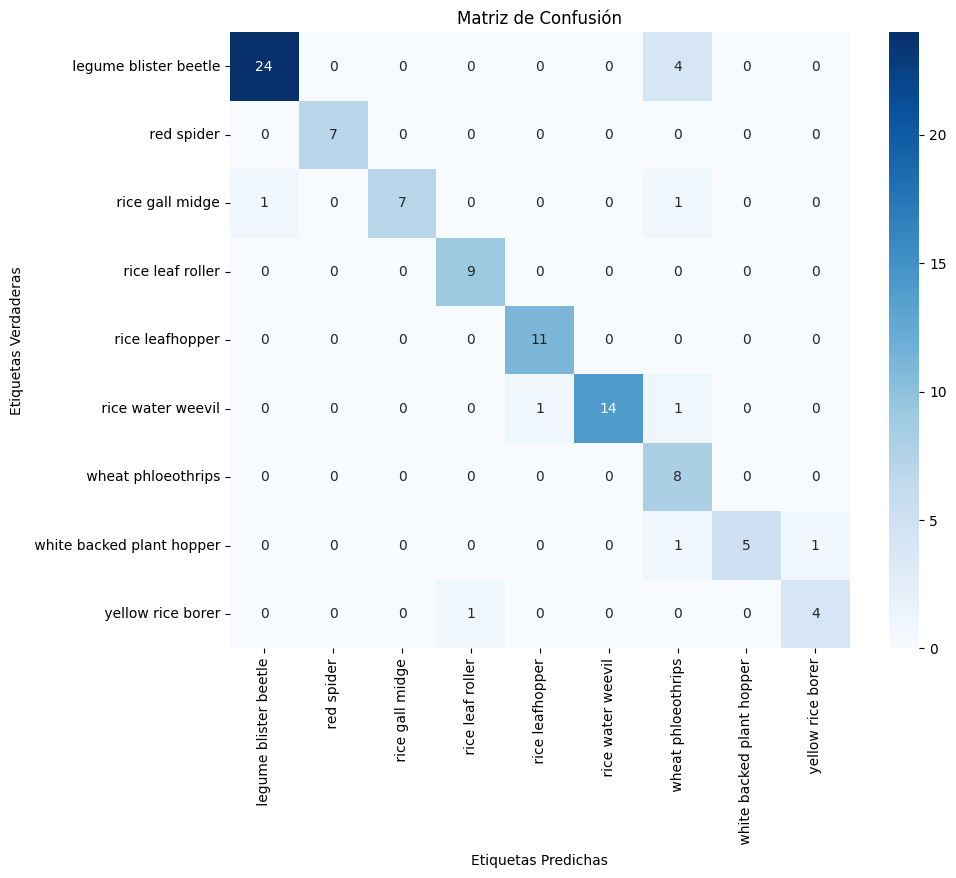

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Obtener las etiquetas verdaderas del conjunto de prueba
true_classes = test_generator.classes

# Obtener las etiquetas predichas por el modelo
predictions = model.predict(test_generator, steps=np.ceil(test_generator.samples / test_generator.batch_size))
predicted_classes = np.argmax(predictions, axis=1)

# Mapeo de índices a clases para las etiquetas verdaderas y predichas
class_labels = list(test_generator.class_indices.keys())

# Generar el reporte de clasificación
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

# Generar la matriz de confusión
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Matriz de Confusión')
plt.ylabel('Etiquetas Verdaderas')
plt.xlabel('Etiquetas Predichas')
plt.show()


In [ ]:
model.save('miModelov2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
import numpy as np


label_map = {v: k for k, v in train_generator.class_indices.items()}


model = load_model('mi_modelo.h5')

def predict_image_class(image_path, model, label_map):
    # Cargar y preprocesar la imagen
    img = load_img(image_path, target_size=(150, 150))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    # Hacer la predicción
    predictions = model.predict(img_array)
    pred_index = np.argmax(predictions, axis=1)[0]
    pred_class = label_map[pred_index]

    return pred_class


test_image_path = '/content/81_jpg.rf.86702ebd21cbc1eca44be91ac273c246.jpg'

# Usar la función para predecir la clase de la imagen
predicted_class = predict_image_class(test_image_path, model, label_map)
print(f'La imagen es: {predicted_class}')


1/1 [==============================] - 1s 894ms/step
La imagen es:  legume blister beetle


#**MODELO 2 VGG16**

In [12]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

# Cargar VGG16 preentrenado y excluir la capa superior
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Congelar las capas del modelo base de VGG16
for layer in vgg16_base.layers:
    layer.trainable = False

# Añadir nuevas capas personalizadas encima del modelo base de VGG16
vgg16_x = vgg16_base.output
vgg16_x = Flatten()(vgg16_x)
vgg16_x = Dense(512, activation='relu')(vgg16_x)
vgg16_x = Dropout(0.5)(vgg16_x)
vgg16_predictions = Dense(9, activation='softmax')(vgg16_x)

vgg16_model = Model(inputs=vgg16_base.input, outputs=vgg16_predictions)
vgg16_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

58889256/58889256 [==============================] - 0s 0us/step


In [14]:
vgg16_model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0   

In [8]:


# Entrenar el modelo VGG16
vgg16_history = vgg16_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // valid_generator.batch_size,
    callbacks=[early_stopping, reduce_lr],
    verbose=2
)



Epoch 1/50
21/21 - 17s - loss: 2.5780 - accuracy: 0.2380 - val_loss: 1.2645 - val_accuracy: 0.5990 - lr: 0.0010 - 17s/epoch - 823ms/step
Epoch 2/50
21/21 - 5s - loss: 1.5037 - accuracy: 0.4834 - val_loss: 1.0325 - val_accuracy: 0.6719 - lr: 0.0010 - 5s/epoch - 228ms/step
Epoch 3/50
21/21 - 5s - loss: 1.2419 - accuracy: 0.5873 - val_loss: 0.7767 - val_accuracy: 0.7708 - lr: 0.0010 - 5s/epoch - 226ms/step
Epoch 4/50
21/21 - 5s - loss: 1.1233 - accuracy: 0.6069 - val_loss: 0.6538 - val_accuracy: 0.7969 - lr: 0.0010 - 5s/epoch - 258ms/step
Epoch 5/50
21/21 - 5s - loss: 1.0313 - accuracy: 0.6401 - val_loss: 0.6890 - val_accuracy: 0.8021 - lr: 0.0010 - 5s/epoch - 218ms/step
Epoch 6/50
21/21 - 7s - loss: 0.9834 - accuracy: 0.7108 - val_loss: 0.5912 - val_accuracy: 0.8177 - lr: 0.0010 - 7s/epoch - 321ms/step
Epoch 7/50
21/21 - 5s - loss: 0.9401 - accuracy: 0.6852 - val_loss: 0.6734 - val_accuracy: 0.7917 - lr: 0.0010 - 5s/epoch - 238ms/step
Epoch 8/50
21/21 - 5s - loss: 0.8716 - accuracy: 0.70

In [12]:
loss, accuracy = vgg16_model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

3/3 [==============================] - 0s 80ms/step - loss: 0.4408 - accuracy: 0.8542
Test Loss: 0.4408233165740967
Test Accuracy: 0.8541666865348816


4/4 [==============================] - 3s 715ms/step
                            precision    recall  f1-score   support

     legume blister beetle       0.92      0.86      0.89        28
                red spider       0.67      0.86      0.75         7
           rice gall midge       0.82      1.00      0.90         9
          rice leaf roller       0.89      0.89      0.89         9
           rice leafhopper       0.83      0.91      0.87        11
         rice water weevil       0.88      0.88      0.88        16
        wheat phloeothrips       1.00      0.88      0.93         8
 white backed plant hopper       1.00      0.71      0.83         7
         yellow rice borer       0.60      0.60      0.60         5

                  accuracy                           0.86       100
                 macro avg       0.85      0.84      0.84       100
              weighted avg       0.87      0.86      0.86       100



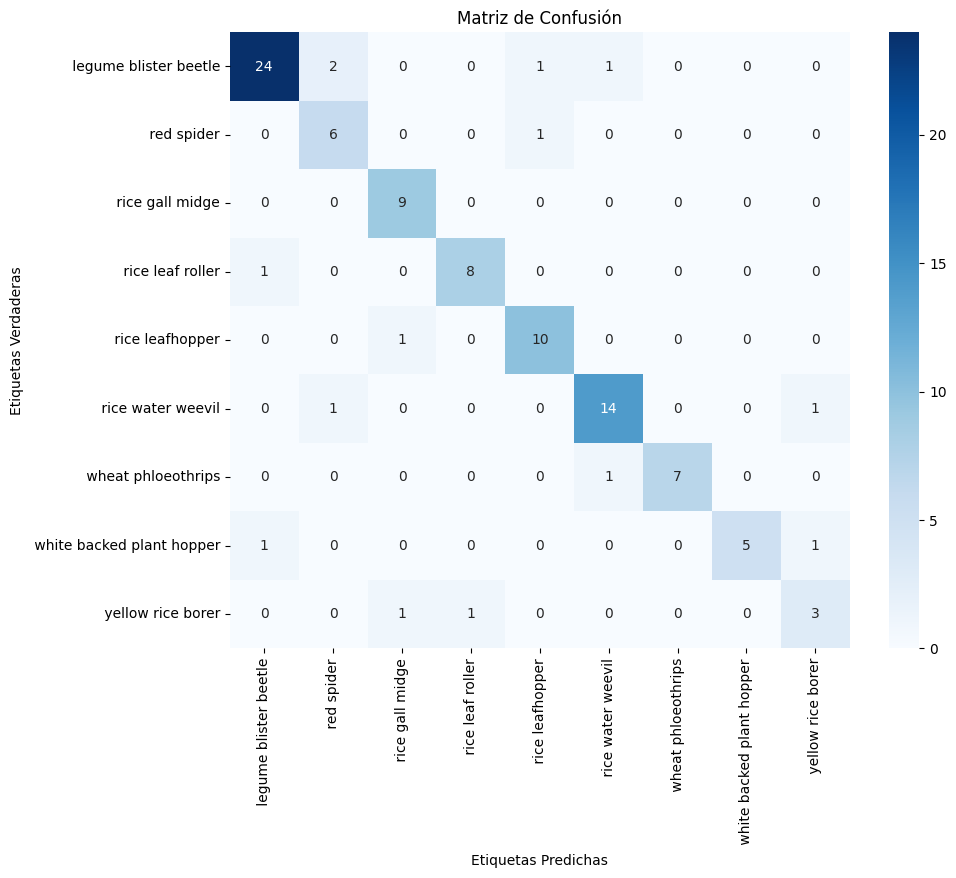

In [11]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Obtener las etiquetas verdaderas del conjunto de prueba
true_classes2 = test_generator.classes

# Obtener las etiquetas predichas por el modelo
predictions2 = vgg16_model.predict(test_generator, steps=np.ceil(test_generator.samples / test_generator.batch_size))
predicted_classes2 = np.argmax(predictions2, axis=1)

# Mapeo de índices a clases para las etiquetas verdaderas y predichas
class_labels2 = list(test_generator.class_indices.keys())

# Generar el reporte de clasificación
report2 = classification_report(true_classes2, predicted_classes2, target_names=class_labels2)
print(report2)

# Generar la matriz de confusión
conf_matrix2 = confusion_matrix(true_classes2, predicted_classes2)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix2, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels2, yticklabels=class_labels2)
plt.title('Matriz de Confusión')
plt.ylabel('Etiquetas Verdaderas')
plt.xlabel('Etiquetas Predichas')
plt.show()

#**Modelo Arquitectura propia**

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Definir el modelo
model_3 = Sequential()

# Primer bloque convolucional
model_3.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model_3.add(BatchNormalization())
model_3.add(MaxPooling2D(pool_size=(2, 2)))
model_3.add(Dropout(0.25))

# Segundo bloque convolucional
model_3.add(Conv2D(64, (3, 3), activation='relu'))
model_3.add(BatchNormalization())
model_3.add(MaxPooling2D(pool_size=(2, 2)))
model_3.add(Dropout(0.25))

# Tercer bloque convolucional
model_3.add(Conv2D(128, (3, 3), activation='relu'))
model_3.add(BatchNormalization())
model_3.add(MaxPooling2D(pool_size=(2, 2)))
model_3.add(Dropout(0.25))

# Aplanar la salida de las capas convolucionales
model_3.add(Flatten())

# Primera capa densa
model_3.add(Dense(512, activation='relu'))
model_3.add(BatchNormalization())
model_3.add(Dropout(0.5))

# Capa de salida
model_3.add(Dense(9, activation='softmax')) # 9 clases

# Compilar el modelo
model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Resumen del modelo
model_3.summary()

# Entrenar el modelo
history_3 = model_3.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // valid_generator.batch_size,
    callbacks=[early_stopping, reduce_lr],
    verbose=2
)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 148, 148, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 74, 74, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 72, 72, 64)        2

In [9]:
loss, accuracy = model_3.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

3/3 [==============================] - 0s 50ms/step - loss: 5.3120 - accuracy: 0.1042
Test Loss: 5.311956882476807
Test Accuracy: 0.1041666641831398


4/4 [==============================] - 1s 147ms/step
                            precision    recall  f1-score   support

     legume blister beetle       0.00      0.00      0.00        28
                red spider       0.43      0.43      0.43         7
           rice gall midge       0.00      0.00      0.00         9
          rice leaf roller       0.00      0.00      0.00         9
           rice leafhopper       0.00      0.00      0.00        11
         rice water weevil       0.00      0.00      0.00        16
        wheat phloeothrips       0.00      0.00      0.00         8
 white backed plant hopper       0.08      1.00      0.14         7
         yellow rice borer       0.00      0.00      0.00         5

                  accuracy                           0.10       100
                 macro avg       0.06      0.16      0.06       100
              weighted avg       0.04      0.10      0.04       100



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


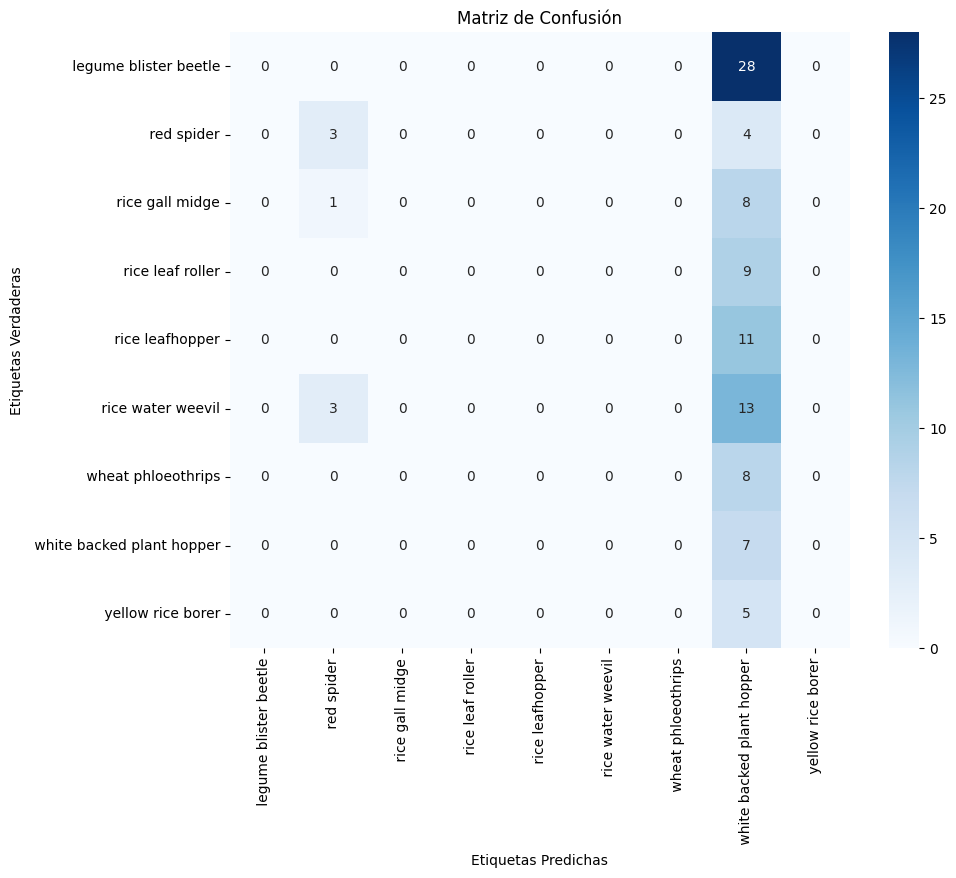

In [8]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Obtener las etiquetas verdaderas del conjunto de prueba
true_classes3 = test_generator.classes

# Obtener las etiquetas predichas por el modelo
predictions3 = model_3.predict(test_generator, steps=np.ceil(test_generator.samples / test_generator.batch_size))
predicted_classes3 = np.argmax(predictions3, axis=1)

# Mapeo de índices a clases para las etiquetas verdaderas y predichas
class_labels3 = list(test_generator.class_indices.keys())

# Generar el reporte de clasificación
report3 = classification_report(true_classes3, predicted_classes3, target_names=class_labels3)
print(report3)

# Generar la matriz de confusión
conf_matrix3 = confusion_matrix(true_classes3, predicted_classes3)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix3, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels3, yticklabels=class_labels3)
plt.title('Matriz de Confusión')
plt.ylabel('Etiquetas Verdaderas')
plt.xlabel('Etiquetas Predichas')
plt.show()

#**Guardar mejor modelo (MOBILENETV2)**

In [15]:
model.save('mi_modelo.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
